In [1]:
# Code taken and modified from https://github.com/vntkumar8/musical-instrument-classification/
# Approach based on Racharla, Karthikeya & Kumar, Vineet & Jayant, Chaudhari & Khairkar, Ankit & Harish, Paturu. (2020). Predominant Musical Instrument Classification based on Spectral Features. 617-622. 10.1109/SPIN48934.2020.9071125. 
from python_speech_features import mfcc
from python_speech_features import logfbank
import scipy.io.wavfile as wav
import pandas as pd
import numpy as np
from statistics import stdev
import librosa
import IPython.display as ipd
# %matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
import seaborn as sn
import pandas as pd
import soundfile as sf
import os
from PIL import Image
import pathlib
import csv
import statistics

# Preprocessing
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier

#Keras
import keras

import warnings
warnings.filterwarnings('ignore')

In [2]:
header = 'filename label'
for i in range(1, 21):
    header += f' mfcc{i}'
header = header.split()

In [3]:
Instruments = 'cel cla flu gac gel org pia sax tru vio voi'.split()
for i in Instruments:
    for filename in os.listdir(f'../IRMAS-TrainingData/{i}'):
        if filename != 'desktop.ini':
            songname = f'../IRMAS-TrainingData/{i}/{filename}'
            y, sr = librosa.load(songname, sr =44100)
            mfcc = librosa.feature.mfcc(y=y, sr=sr)
            to_append = f'{filename} {i}'    
            for e in mfcc:
                to_append += f' {np.mean(e)}'
            file = open('data_SVM.csv', 'a', newline='')
            with file:
                writer = csv.writer(file)
                writer.writerow(to_append.split())

In [5]:
df = pd.read_csv('data_SVM.csv')
df.head()

,filename,label,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
0,008__[cel][nod][cla]0058__1.wav,cel,-548.29930,189.76556,-21.121988,15.259335,18.991768,16.186731,-1.031204,-5.983769,...,-3.192724,-0.564254,1.159621,-0.287216,-1.051063,2.558362,7.008935,9.611934,6.723992,2.892502
1,008__[cel][nod][cla]0058__2.wav,cel,-492.25302,180.43597,-30.720634,16.488260,7.242813,15.498132,-5.703055,0.039674,...,4.937367,-3.774964,-4.976338,-5.985732,-12.421291,-7.708522,-5.190786,0.197547,10.872709,21.063337
2,008__[cel][nod][cla]0058__3.wav,cel,-445.28700,170.88661,-36.930515,13.339684,2.763019,15.562643,-6.049806,-6.221480,...,0.937475,-1.129981,0.303812,2.144062,3.028069,4.692125,1.315577,-4.312213,-6.950765,-1.198687
3,012__[cel][nod][cla]0043__1.wav,cel,-370.56335,182.48265,-35.701280,31.877964,1.929514,20.379725,-10.143896,2.619544,...,-4.954261,-3.459521,-4.016848,-2.542540,2.515919,3.337309,-1.405248,-2.197753,0.097689,-1.399736
4,012__[cel][nod][cla]0043__2.wav,cel,-359.07788,171.01855,-36.208290,24.581501,-6.047874,18.534256,-11.615797,3.629997,...,-0.709438,-2.380702,-7.200488,-5.400430,2.223381,5.510553,1.154641,3.953078,4.156675,3.527656


In [6]:
df = df.drop(['filename'],axis=1)
df1 = shuffle(df)
df1

,label,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
6545,voi,-164.299070,135.56330,-47.155437,52.277126,-1.369644,41.609270,-8.711507,28.744932,-2.852260,...,-5.249733,4.607578,1.771282,1.141957,2.430669,3.138020,9.892318,0.888957,6.979161,0.280278
3332,org,-114.691574,147.56757,-45.593860,55.694996,-19.919535,26.991613,-18.440954,18.346996,1.194722,...,4.530964,8.035870,4.203896,1.186106,2.393851,-2.070289,2.438177,-3.549993,0.642349,-1.809845
4662,sax,-188.314250,183.40854,-80.342500,59.639435,-5.977563,12.059595,1.696743,9.952133,-1.350428,...,-0.127589,-8.090937,0.842464,-0.371299,-1.940742,0.621825,4.913547,1.914048,2.151539,-0.968109
5441,vio,-249.870900,185.54256,-97.595800,29.487550,-3.166301,4.049775,4.287407,7.482375,-6.684964,...,-5.861641,-9.062986,-8.279797,-8.682949,1.356631,-4.067735,-8.285023,-5.065708,-3.079066,-13.847275
2678,gel,-187.094830,126.22550,-43.176632,63.849022,50.390000,25.715680,-1.330472,12.625624,-2.215952,...,5.517783,0.754177,3.712478,6.063928,-0.599599,2.942228,2.306183,2.689959,8.307112,3.711274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4784,tru,-145.373520,111.34817,-41.367120,75.023710,-19.586031,37.448050,-20.578080,23.336220,-11.811517,...,1.406838,5.354527,-6.035802,-7.220123,-7.372259,-4.959257,6.857984,-0.650757,1.955542,-9.078320
4133,pia,-463.794770,229.97916,-7.589781,11.897976,27.274874,1.131655,1.866597,-5.334727,-7.297444,...,-8.877189,-2.489083,-0.013083,-0.880826,-4.849967,-10.872282,-5.538690,-4.311897,-9.889826,-3.700426
6394,voi,-263.226750,206.26611,-21.030474,21.652224,15.611428,-3.349603,-5.911873,-2.279954,-3.635234,...,3.238989,0.564945,2.241521,-1.019544,-0.567227,1.435965,1.422866,-0.208558,1.413558,1.991894
2080,gel,-248.572630,136.82982,20.594269,72.149086,-13.327978,40.162290,-13.468472,8.942604,6.600642,...,-0.383962,-11.322007,1.990736,-8.821871,-2.564849,-6.311043,2.881165,1.687390,-3.607298,-6.365889


In [12]:
instru_list = df1.iloc[:, 0]
encoder = LabelEncoder()
y = encoder.fit_transform(instru_list)
y

array([10,  5,  7, ..., 10,  4,  1])

In [13]:
scaler = StandardScaler()
X = scaler.fit_transform(np.array(df1.iloc[:, 1:], dtype = float))
X

array([[ 0.80884416, -1.03562751, -0.78235531, ...,  0.51181029,
         1.26050835,  0.40371024],
       [ 1.21931119, -0.69191774, -0.73275603, ..., -0.226728  ,
         0.15490549,  0.05129394],
       [ 0.61013549,  0.33429139, -1.83645277, ...,  0.68236156,
         0.41821836,  0.19321931],
       ...,
       [-0.0097126 ,  0.98875602,  0.04743362, ...,  0.3292093 ,
         0.2894606 ,  0.69230632],
       [ 0.11153991, -0.99936414,  1.36953121, ...,  0.64465091,
        -0.58654342, -0.71690192],
       [-0.45054574,  0.95047951, -0.11486319, ..., -0.62243108,
        -0.14968274,  0.66414227]])

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, confusion_matrix

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Create and train a Support Vector Classifier with an RBF kernel
svclassifier = SVC(kernel='rbf', C=10.0, gamma=0.1, degree=3)
svclassifier.fit(X_train, y_train)

# Make predictions on the test set
predicted_labels = svclassifier.predict(X_test)

# Print evaluation metrics
print("Recall: ", recall_score(y_test, predicted_labels, average='weighted'))
print("Precision: ", precision_score(y_test, predicted_labels, average='weighted'))
print("F1-Score: ", f1_score(y_test, predicted_labels, average='weighted'))
print("Accuracy: %f  ," % accuracy_score(y_test, predicted_labels, normalize=True), accuracy_score(y_test, predicted_labels, normalize=False))
print("Number of samples:", y_test.shape[0])

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, predicted_labels))

Recall:  0.6845637583892618
Precision:  0.6889274997315993
F1-Score:  0.6839180323887839
Accuracy: 0.684564  , 918
Number of samples: 1341
Confusion Matrix:
[[ 58   4   2   2   2   0   4   2   0   3   0]
 [  4  57   1   7   3   1   2   4   6   6   2]
 [  2   7  51   4   6   7   5   4   2   1   3]
 [  3   1   3 111   3   0   2   0   1   4   3]
 [  1   1   4   6 113   8   3   6   0   4  10]
 [  0   6   3   5   4  99   2   3   2   3   6]
 [  1   8   6   4   7   7 107   2   3   1   1]
 [  3   8   3   7   5   4   3  77   4   5   4]
 [  1   8   2   4   3   6   5   3  77   6   1]
 [  4   9   7   4  11   1   6   7   2  68   4]
 [  1   2   3  12  17   3   3   4   2   3 100]]


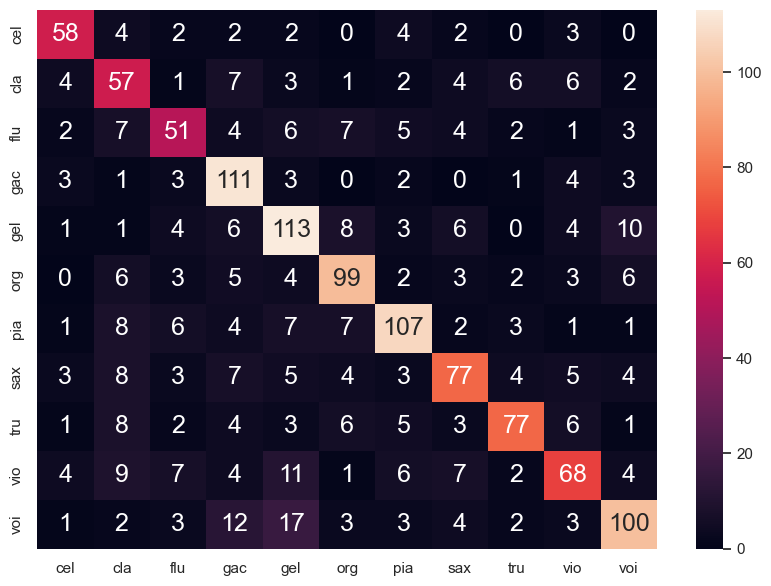

In [31]:
import seaborn as sns
class_labels = ['cel', 'cla', 'flu', 'gac', 'gel', 'org', 'pia', 'sax', 'tru', 'vio', 'voi']
df_cm = pd.DataFrame(confusion_matrix(y_test, predicted_labels),index=class_labels, columns=class_labels)
plt.figure(figsize = (10,7))
sn.set(font_scale=1.0)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 18},fmt='g')# font size

plt.show()